In [1]:
import pandas as pd
import pystan
import numpy as np

In [2]:
from scipy.special import betaln as lbeta
from scipy.special import beta 
from scipy.special import gammaln

def prob_2_beats_1_parameters(alpha_1, beta_1, alpha_2, beta_2):
    total = 0.0
    for i in np.arange(0,alpha_2-1):
        total += np.exp( lbeta(alpha_1+i,beta_1 + beta_2) - np.log(beta_2+i) - lbeta(1+i,beta_2) - lbeta(alpha_1,beta_1))
    return total

def prob_1_diff_2(alpha_1, beta_1, alpha_2, beta_2):
    p = prob_2_beats_1_parameters(alpha_1, beta_1, alpha_2, beta_2)
    return np.abs(p - (1-p))

def log_beta_binomial_density(k,n,alpha,beta):
    uno = gammaln(n+1) - (gammaln(k+1) + gammaln(n-k+1))
    dos = gammaln(k+alpha) + gammaln(n-k+beta) - gammaln(n+alpha+beta)
    tres = gammaln(alpha + beta) - (gammaln(alpha) + gammaln(beta))
    return uno + dos + tres



In [7]:
%timeit log_beta_binomial_density(100,500,100,500)

The slowest run took 6.87 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 9.75 µs per loop


In [19]:
import cython
%load_ext cython



The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [88]:

sin(10)

NameError: name 'sin' is not defined

In [105]:
%%cython -a
cimport cython
from scipy.special import gammaln
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

cdef np.ndarray ldbetabinomial(np.ndarray[double, ndim=1] k,
                                 np.ndarray[double, ndim=1] n,
                                 double alpha, 
                                 double beta):
    cdef np.ndarray ll = gammaln(n+1) - (gammaln(k+1) + gammaln(n-k+1)) + gammaln(k+alpha) + gammaln(n-k+beta) - gammaln(n+alpha+beta) + gammaln(alpha + beta) - (gammaln(alpha) + gammaln(beta))
    return ll


def cy_log_beta_binomial_density(np.ndarray[double, ndim=1] k,
                                 np.ndarray[double, ndim=1] n,
                                 double alpha, 
                                 double beta):
    cdef np.ndarray uno = ldbetabinomial(k,n,alpha,beta)
    return uno

In [106]:
a = data2.aCount.values.astype(float)
b = data2.totalCount.values.astype(float)

%timeit log_beta_binomial_density(a, b,100.1,500.1)
%timeit cy_log_beta_binomial_density(a, b,100.1,500.1)

10 loops, best of 3: 20.8 ms per loop
10 loops, best of 3: 20.6 ms per loop


In [107]:
cy_log_beta_binomial_density(a, b,100.1,500.1)

array([ -15.13386411,  -15.99168863,  -24.54848313, ..., -151.2956707 ,
        -77.7576571 ,  -96.99489657])

In [3]:
from scipy.optimize import minimize
from scipy import logaddexp
        
def beta_mom(mean=None,variance=None):
    """
        Returns the parameters of a beta distributions using the method of moments
    """
    
    common_factor = mean*((1-mean)/variance-1)
    return [mean*common_factor,   (1-mean)*common_factor]

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

def beta_pars_from_cdf(cdf_vals = None, x_points=None,weights=None):
    """
        Infers the parameters of a beta distributions starting from the CDF by minimising the first and second moments of the distribution
    """
    m,s2 = weighted_avg_and_std(x_points,weights=cdf_vals)
    
    def beta_pdf_delta(beta_par,local_m=m,local_s2=s2, x_points = x_points, weights=None):
        proposed_cdf = get_beta_cdf([beta_par], x_points=x_points, weights=None) 
        proposed_m, proposed_s2 =  weighted_avg_and_std(x_points, weights= proposed_cdf)
        delta =  (local_m - proposed_m)**2 + (local_s2 - proposed_s2)**2
        return(delta)
    
    x0 = beta_mom(m, s2)
    res = minimize(beta_pdf_delta, x0, method='nelder-mead', options={'xtol': 1e-8,'disp': False})
    back = res.x.astype(list).astype(float)
    return( [back[0],back[1]] )



def get_beta_cdf(pars,x_range=[0,1], x_n_points=500, x_points=None, weights=None):
    """
        For a set of beta distribitions parametrised as [[alpha_1,beta_1],[alpha_2,beta_2]] obtained the conflated distribution.
        See function beta_conflation for more details 
    """
    if weights is None:
        weights = np.ones(len(pars))
    if len(weights) != len(pars):
        raise ValueError('Number of weights must be equal to number of parameters')
    
    weights /= np.max(weights)
    
    if x_points is None:
        x_points = np.linspace(x_range[0], x_range[1], x_n_points)
    it = iter(pars)
    initializer = next(it)

    w_it = iter(weights)
    w_init = next(w_it)
    log_accum_value = ss.beta.logpdf(x_points, initializer[0], initializer[1])
    w_sum = w_init

    for next_pars in it:
        w_value = next(w_it)
        w_prop = w_sum/(w_sum + w_value)
        # log (first^w_prop)*(second/(1-w_prop)) = log(first) - log(w_prop) + log(second) - log((1-w_prop))
        log_accum_value = w_prop*log_accum_value + (1.0-w_prop)*ss.beta.logpdf(x_points, next_pars[0], next_pars[1])
        w_sum += w_value
    return np.exp(log_accum_value - logaddexp.reduce(log_accum_value))


def beta_conflation(pars=None, x_range=[1e-8,1.0-1e-8], x_n_points=500, initializer=None, weights=None):
    """
        Performs conflation on beta distributions following Hill (2011, https://arxiv.org/pdf/0808.1808.pdf) and 
        Hill and Miller (2011, http://dx.doi.org/10.1063/1.3593373)
        
        pars = parameters of the beta distributions list of list where each list provides the pair alpha beta: e.g. [[alpha_1,beta_1],[alpha_2,beta_2]]
        x_range = value range to consider the conflation list of to values [min, max]
        x_n_points= number of points to evalue on the x_range
        initializer = initial set of paramaters to consider 
        weights = weights to combine the differet distributions. Internally will be normalised by dividing by max value as per Hill and Miller (2011)
        
        Return a list of two values [alpha, beta] corrsponding to the parameters of the combined distribution
        
    """
    x_points = np.linspace(x_range[0], x_range[1], x_n_points)
    
    it = iter(pars)
    if initializer is None:
        try:
            initializer = next(it)
        except StopIteration:
            raise TypeError('Sequence with no initial value')
            
    if weights is None:
        weights = np.ones(len(pars))
    if len(weights) != len(pars):
        raise ValueError('Number of weights must be equal to number of parameters')
    
    weights /= np.max(weights)
    
    accum_value = initializer
    
    w_it = iter(weights)
    w_init = next(w_it)
    
    w_sum = w_init
    for next_pars in it:
        w_value = next(w_it)
        cdf_vals = get_beta_cdf([accum_value,next_pars], x_points=x_points, weights=[w_sum, w_value])
        accum_value = beta_pars_from_cdf(cdf_vals, x_points=x_points,weights=weights)
        w_sum += w_value

    return accum_value

In [4]:
def get_mus(K=3, center=0.5, denom_val = 2):
    mus = np.zeros(K)
    center_idx = int(0.5*(K-1))
    mus[ center_idx ] = 0.5
    denominator = np.sqrt(denom_val)
    for i in range(int(K - 0.5*(K-1)),K):
      mus[i] = mus[i-1]/denominator;
      mus[K - i - 1] = 1 - mus[i-1]/denominator;
        
    print(mus)

def get_mus_log(K=3, center=0.5):
    start = np.log(1)
    end=np.log(0.5)
    step= (end - start)/((K-1)/2)
    mus = np.sort(
        np.hstack(
            [np.exp(np.arange(start,end,step)),
            0.5,
            1 - np.exp(np.arange(start,end,step))]
        )
    )

    mus[mus == 0] = 0.01
    mus[mus == 1] = 0.99
    return mus

def get_mu_linear(K=3):
    back = np.sort(np.hstack([np.arange(0,1.0,1.0/(K-1))] + [.99]))
    back[back == 0] = 0.01
    back[back == 1] = 0.99
    #back[back == 0.5] = 0.53


    return back

    
def get_prior_counts(K=3, center_prop=0.9):
    pc = np.ones(K)
    pc[int(0.5*(K-1))] = 10
    return pc

get_mu_linear(K=7)


array([ 0.01      ,  0.16666667,  0.33333333,  0.5       ,  0.66666667,
        0.83333333,  0.99      ])

In [5]:
files = !ls /Users/inti.pedroso/DATA/ASE/phaser_gene/
files
data = pd.concat([ pd.read_table( "".join(["/Users/inti.pedroso/DATA/ASE/phaser_gene/",f])) for f in files ])


In [6]:
#data = pd.read_table("/Users/inti.pedroso/DATA/ASE/phaser/ERR883767/ERR883767.phaser_ase.gene.txt")
data.head()
data2 = data[data["totalCount"] > 10]
data2.shape

(185713, 12)

### Dirichlet Prios Mixture

$$G (\alpha) = \sum_{k=1}^{\infty} = DP(\alpha, BB(a_0,b_0))$$

Stick Breaking Prior

$$\pi_c = \upsilon_c \prod_{i=1}^{c-1}(1-\upsilon_i)$$



In [27]:
%%file /Users/inti.pedroso/DATA/ASE/mixture_BBv5.stan
data {
  int<lower=1> N; // total number of observations
  int<lower=1> K; // total number of mixture distributions
  int<lower=0> x[N]; // counts for one allele
  int<lower=0> n[N]; // total counts for unit
  vector<lower=0,upper=1>[K] mu; // means of mixture distributions
}
parameters {
  vector<lower=1.1>[K] M; // M_k = alpha_k + _beta_k. <lower=5,upper=1000>
  real <lower=0.0001,upper=1-0.0001> v[K];
  real <lower=0.0001> alpha_SB;

}

transformed parameters{
  simplex[K] theta; // mixture proportions
  theta[1] = v[1];
  // stick-break process based on The BUGS book Chapter 11 (p.294)
  for(j in 2:(K-1)){
      theta[j]= v[j]*(1-v[j-1])*theta[j-1]/v[j-1]; 
  }
  theta[K]=1-sum(theta[1:(K-1)]); // to make a simplex.
}

model {
  // clusters parameters
  real alpha[K]; 
  real beta[K];
  // parameters for stick breaking prior for mixture coefficients
  vector[K] log_theta = log(theta); // cache log calculation

  // Priors
  alpha_SB ~ gamma(1,1);
  v ~ beta(1,alpha_SB);
  M ~ pareto(10.0, 1.5);

  // alpha and beta parameters for each of the K distributions
  for (k in 1:K) {
    alpha[k] = mu[k]*M[k];
    beta[k] = (1-mu[k])*M[k];
  }

  // likelihood 
  for (i in 1:N) {
    vector[K] lps; // = log_theta;
    for (k in 1:K) {
      lps[k] += log_theta[k] + beta_binomial_lpmf(x[i]|n[i], alpha[k], beta[k]);
    }
    target += log_sum_exp(lps);
  } 
}

Overwriting /Users/inti.pedroso/DATA/ASE/mixture_BBv5.stan


In [15]:
%%file /Users/inti.pedroso/DATA/ASE/mixture_BBv4.stan
data {
  int<lower=1> N; // total number of observations
  int<lower=1> K; // total number of mixture distributions
  int<lower=0> x[N]; // counts for one allele
  int<lower=0> n[N]; // total counts for unit
  real<lower=0,upper=1> mu[K]; // means of mixture distributions
}
parameters {
  simplex[K] kappa; // prior count proportions
  real<lower=10,upper=600> dirMass; // Total mass for dirichlet prior
  simplex[K] theta; // mixture proportions
  vector<lower=2>[K] M; // M_k = alpha_k + _beta_k. <lower=5,upper=1000>
} 
model {
  real alpha[K];
  real beta[K];
  vector[K] lambda; // prior pseudocounts for each mixture distribution

  vector[K] log_theta = log(theta); // cache log calculation
  // alpha and beta parameters for each of the K distributions
  for (k in 1:K) {
    alpha[k] = mu[k]*M[k];
    beta[k] = (1-mu[k])*M[k];
    lambda[k] = kappa[k]*dirMass;
  }

  // priors for allocations proportions. This are fixed
  theta ~ dirichlet(lambda);
  // priors for each component 
  M ~ pareto(0.1, 1.5);
    
  // likelihood 
  for (i in 1:N) {
    vector[K] lps = log_theta;
    for (k in 1:K)
      lps[k] += beta_binomial_lpmf(x[i]|n[i], alpha[k], beta[k]);
    target += log_sum_exp(lps);
  } 
}

Overwriting /Users/inti.pedroso/DATA/ASE/mixture_BBv4.stan


In [23]:
data2 = data[data["totalCount"] > 10]
data2 = data2[data2["aCount"] > 10]

K=11
dat2stan = {'N': data2.shape[0],
            'K':K,
            'mu': get_mu_linear(K),
            'lambda': get_prior_counts(K=K),
            'x': data2.aCount.values,
            'n': data2.totalCount.values
           }
data2.shape

(157446, 12)

In [17]:
get_mu_linear(5)

array([ 0.01,  0.25,  0.5 ,  0.75,  0.99])

In [7]:
#%pylab inline

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams['figure.figsize'] = (12, 8)
import scipy.stats as ss

def plot_normal(x_range, mu=0, sigma=1, cdf=False, **kwargs):
    '''
    Plots the normal distribution function for a given x range
    If mu and sigma are not provided, standard normal is plotted
    If cdf=True cumulative distribution is plotted
    Passes any keyword arguments to matplotlib plot function
    '''
    x = x_range
    if cdf:
        y = ss.norm.cdf(x, mu, sigma)
    else:
        y = ss.norm.pdf(x, mu, sigma)
    plt.plot(x, y, **kwargs)
    
def plot_beta(x_range, alpha=1, beta=1, cdf=False, w = 1, color=None, normalise=True, **kwargs):
    '''
    Plots the normal distribution function for a given x range
    If mu and sigma are not provided, standard normal is plotted
    If cdf=True cumulative distribution is plotted
    Passes any keyword arguments to matplotlib plot function
    '''
    x = x_range
    if cdf:
        y = ss.beta.cdf(x, alpha, beta)
    else:
        y = w*ss.beta.pdf(x, alpha, beta)
    if normalise:
        y /= np.sum(y)
    plt.plot(x, y,color=color, **kwargs)

In [14]:
#sm_BB = pystan.StanModel(file="/Users/inti.pedroso/DATA/ASE/mixture_BBv4.stan")
#fit_vb = sm_BB.vb(data=dat2stan, tol_rel_obj = 1e-3)



In [28]:
sm_BB_DPM = pystan.StanModel(file="/Users/inti.pedroso/DATA/ASE/mixture_BBv5.stan")
#sm_BB_dirPrior = pystan.StanModel(file="/Users/inti.pedroso/DATA/ASE/mixture_BB_dirPrior.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_abcaf36039c41c21521a267e028bd8be NOW.


In [30]:
#fit_DPM_vb = sm_BB_DPM.vb(data=dat2stan, tol_rel_obj = 1e-3)
fit_DPM_hmc = sm_BB_DPM.sampling(data=dat2stan, iter=1000, chains=2, n_jobs=1)

RuntimeError: Initialization failed.

(array([ 0.04244122,  0.01273237,  0.02546473,  0.05941771,  0.10610305,
         0.14430014,  0.13156778,  0.17825312,  0.11883541,  0.15278839,
         0.19522961,  0.16127663,  0.24191495,  0.31830914,  0.27586792,
         0.39470334,  0.49656226,  0.73423309,  0.93370682,  1.00585689,
         1.74008998,  2.21543163,  3.16187081,  4.49028096,  4.24836601,
         6.28554452,  5.16509634,  4.06162465,  2.77141159,  2.04142263,
         1.79950768,  1.38782786,  0.84882438,  0.82335965,  0.65359477,
         0.40319158,  0.47534165,  0.27586792,  0.24191495,  0.22493846,
         0.24191495,  0.14430014,  0.14854427,  0.10610305,  0.07639419,
         0.06790595,  0.02122061,  0.03395298,  0.03395298,  0.08063832]),
 array([ 0.  ,  0.02,  0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,
         0.18,  0.2 ,  0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,
         0.36,  0.38,  0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,
         0.54,  0.56,  0.58,  0.6 ,  0.62,  0.64,  0.66

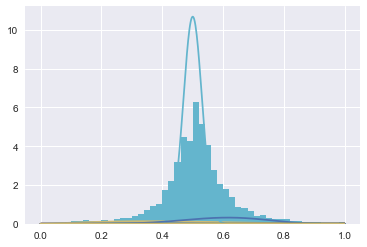

In [34]:
x = np.linspace(0, 1, 500)

model_fit = fit_DPM_vb

Ms = model_fit['mean_pars'][:K]
v = model_fit['mean_pars'][K:(2*K)]
theta = model_fit['mean_pars'][(2*K+1):]



# dirMass = model_fit['mean_pars'][K]
# theta = model_fit['mean_pars'][K+1:(2*K+1)]
# = model_fit['mean_pars'][(2*K+1):]

pars_df = pd.DataFrame([dat2stan['mu'],
                        theta,
                        Ms,
                        dat2stan['mu']*Ms, 
                        (1-dat2stan['mu'])*Ms ],
             index=["mu","theta","M","alpha","beta"]).T

for i in np.arange(len(Ms)):
    m = pars_df.loc[i,"mu"]
    M= pars_df.loc[i,"M"]
    w = 1*pars_df.loc[:,"theta"].values[i]
    plot_beta(x, alpha=m*M,beta=(1-m)*M, w= w, normalise=False)

plt.hist(dat2stan['x']/dat2stan['n'],bins=50, density=True)

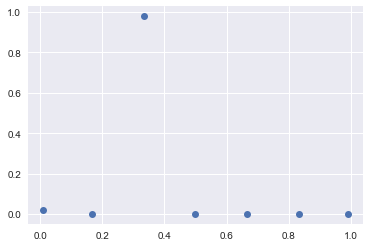

In [25]:
plt.plot(pars_df.mu.values,pars_df.theta.values,'o')

In [35]:
plot_beta(x, alpha=m*M,beta=(1-m)*M, w= w, normalise=False)



,mu,theta,M,alpha,beta
0,0.01,0.000230,1.908591,0.019086,1.889505
1,0.10,0.001596,41.702107,4.170211,37.531897
2,0.20,0.000499,2.526337,0.505267,2.021069
3,0.30,0.000918,2.798123,0.839437,1.958686
4,0.40,0.069150,5.978130,2.391252,3.586878
5,0.50,0.810711,273.402525,136.701263,136.701263
6,0.60,0.106083,14.018678,8.411207,5.607471
7,0.70,0.009062,3.106671,2.174670,0.932001
8,0.80,0.000858,1.845951,1.476761,0.369190
9,0.90,0.000325,1.726098,1.553489,0.172610


In [590]:
data2.head()

,contig,start,stop,name,aCount,bCount,totalCount,log2_aFC,n_variants,variants,gw_phased,bam
5,B07,285804,289743,LOC100645794,8,9,17,-0.169925,1,B07_287747_G_A,0,ERR883767
7,B07,291932,299058,LOC100644253,42,46,88,-0.131245,2,"B07_298584_T_C,B07_298620_C_T",0,ERR883767
10,B07,317746,321001,LOC100649211,11,11,22,0.000000,1,B07_319859_G_A,0,ERR883767
11,B07,321359,323879,LOC100647848,23,15,38,0.616671,1,B07_321560_G_T,0,ERR883767
12,B07,323979,327132,LOC100643240,13,5,18,1.378512,1,B07_325518_G_A,0,ERR883767


In [7]:
def get_pars_list(pars_df):
    pars = list() 
    for i in np.arange(pars_df.shape[0]):
        pars.append([pars_df.loc[i,"alpha"], pars_df.loc[i,"beta"]])
    return pars

def get_mixture_membership(a,b,pars):
    total = a + b
    w = [ log_beta_binomial_density(a,total, p[0],p[0]+p[1]) for p in pars ]
    w -= logaddexp.reduce(w)
    return np.exp(w)



def unit_posterior(a,b, par_list, weights=None, return_originals=True): 
    unit_components = list()
    for i in np.arange(len(par_list)):
        unit_components.append([par_list[i][0] + a ,par_list[i][1] + b])
        
    w = get_mixture_membership(a,b,par_list)
    if weights is not None:
        w = weights * w 

    a_w,b_w = beta_conflation(pars=unit_components, weights=w)
    back = {'alpha_post': a_w, 'beta_post': b_w}
    if return_originals:
        back['a_counts'] = a 
        back['b_counts'] = b 
    return back

from tqdm import tnrange, tqdm_notebook

def get_observation_post( counts, prior_pars, weights=None):
    back = list()
    for i in tnrange(counts.shape[0]):
        back.append( unit_posterior(a=counts[i,0],b=counts[i,1],par_list=prior_pars, weights=weights) )
    return back








In [38]:
pars = get_pars_list(pars_df)
post = get_observation_post( data2.loc[:,["aCount","bCount"]].drop_duplicates().values,
                            prior_pars = pars,
                            weights = pars_df.theta.values)
post = pd.DataFrame(post, columns=['a_counts','b_counts','alpha_post','beta_post'])



In [60]:
post.loc[:,"logFC"] = np.log(post.alpha_post/post.beta_post)
post.loc[:,"pASE"] = post.apply(lambda x: prob_1_diff_2(x['alpha_post'],x['beta_post'],136.701263,136.701263),axis=1)

post = post.sort_values("pASE", ascending= False)

post.head(50)

/Users/inti.pedroso/anaconda2/envs/ase_dev/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in absolute
  del sys.path[0]


,a_counts,b_counts,alpha_post,beta_post,logFC,pASE
5528,1729,5451,1735.540220,5456.693224,-1.145524,1.0
2210,683,3174,686.736291,3178.162389,-1.532108,1.0
3693,328,1073,335.111113,1079.360904,-1.169662,1.0
5542,234,2255,236.583080,2261.679666,-2.257564,1.0
3107,125,592,128.725909,596.199157,-1.532889,1.0
4693,60,238,66.690064,244.476814,-1.299064,1.0
5313,33,172,36.704006,176.482366,-1.570335,1.0
970,38,180,42.320262,184.716403,-1.473556,1.0
2665,12,137,14.619429,143.908396,-2.286826,1.0
2890,185,803,189.035813,807.183535,-1.451615,1.0


In [64]:
(post.pASE > 0.9).sum(), post.shape

(1088, (5548, 6))

/Users/inti.pedroso/anaconda2/envs/ase_dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


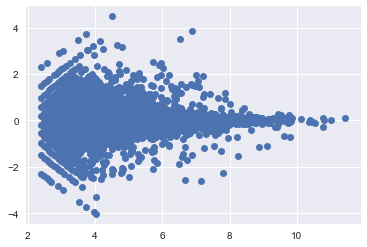

In [40]:
plt.plot(np.log(post.a_counts + post.b_counts), np.log(post.a_counts /post.b_counts),'o')

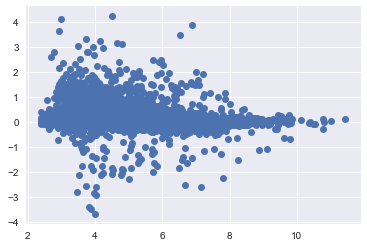

In [41]:
plt.plot(np.log(post.a_counts + post.b_counts), np.log(post.alpha_post/post.beta_post),'o')

/Users/inti.pedroso/anaconda2/envs/ase_dev/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


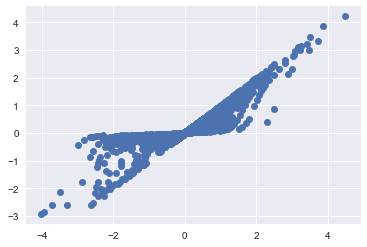

In [42]:
plt.plot(np.log(post.a_counts / post.b_counts), np.log(post.alpha_post/post.beta_post),'o')

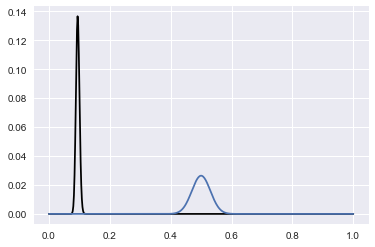

In [8]:
x = np.linspace(0, 1, 500)

plot_beta(x,236.583080,2261.679666, color="black")
plot_beta(x,136.701263,136.701263)



array([5.62195600e-04, 2.80821438e-03, 5.53677552e-03, 8.37844774e-03,
       1.14116024e-02, 2.70461905e-05, 1.51327929e-02, 1.77963759e-02,
       2.46097185e-02, 2.93418742e-02, 9.68596782e-05, 4.12377134e-02,
       2.79037301e-03, 5.77344601e-02, 7.10284127e-02, 3.39522082e-02,
       3.46460572e-02, 3.57759202e-02, 3.53558379e-02, 3.49812780e-02,
       3.67958363e-02, 5.62195600e-04, 2.80821438e-03, 5.53677552e-03,
       8.37844774e-03, 1.14116024e-02, 2.70461905e-05, 1.51327929e-02,
       1.77963759e-02, 2.46097185e-02, 2.93418742e-02, 9.68596782e-05,
       4.12377134e-02, 2.79037301e-03, 5.77344601e-02, 7.10284127e-02,
       3.39522082e-02, 3.46460572e-02, 3.57759202e-02, 3.53558379e-02,
       3.49812780e-02, 3.67958363e-02])

In [44]:
from scipy.special import beta as Beta
from scipy.special import comb
from scipy import stats as ss
alpha_ = 138.43377090243672
beta_ = 138.43377090243672
a = 1
b = 10
comb(a+b, a)  * Beta(alpha + a, beta + b) / Beta(alpha, beta)

import scipy

NameError: name 'alpha' is not defined

In [570]:
np.exp(log_beta_binomial_density(k=199,n=200,alpha=50,beta=50))

7.810233845074794e-28

In [565]:
np.log(scipy.misc.comb(b, a)) + ss.beta.logpdf(a/(a+b),alpha_ +a , beta_ + b)  - ss.beta.logpdf(a/(a+b),alpha_, beta_ )

/Users/inti.pedroso/anaconda2/envs/ase_dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `comb` is deprecated!
Importing `comb` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.comb` instead.
  """Entry point for launching an IPython kernel.


6.454519397278034

In [578]:
from scipy.special import betaln

def log_beta_binomial_probability(k,n,alpha,beta):
    return np.log(comb(n,k)) + betaln(k+alpha,n-k+beta) - betaln(alpha,beta)

log_beta_binomial_probability(138,138*2, 138,138)

-3.383924067719363

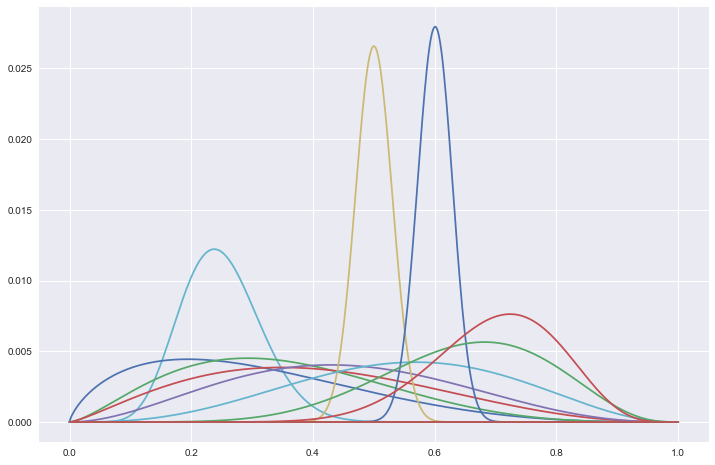

In [461]:
g = list()
pars = list()
gene_a = 30
gene_b = 70

for i in np.arange(pars_df.shape[0]):
    pars.append([pars_df.loc[i,"alpha"], pars_df.loc[i,"beta"]])
    
for i in np.arange(pars_df.shape[0]):
    g.append([pars_df.loc[i,"alpha"] + gene_a ,pars_df.loc[i,"beta"] + gene_b])
    
w = pars_df.theta.values
x = np.linspace(0, 1, 500)
for i in np.arange(len(g)):
    plot_beta(x,alpha=pars[i][0],beta=pars[i][1], w=w[i],normalise=True)



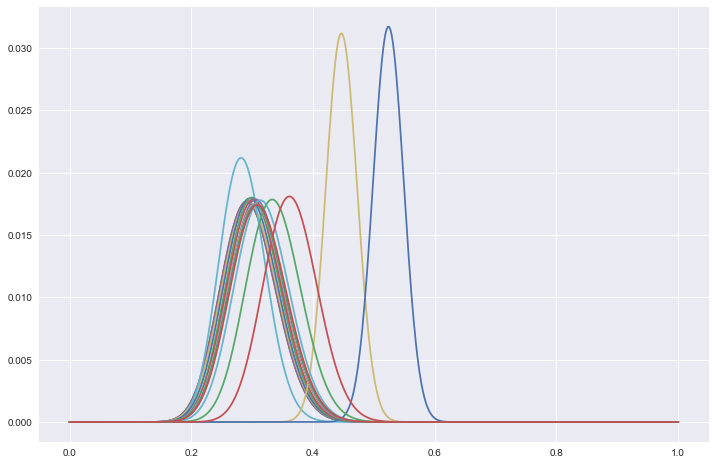

In [462]:
for i in np.arange(len(g)):
    plot_beta(x,alpha=g[i][0],beta=g[i][1], w=w[i],normalise=True)

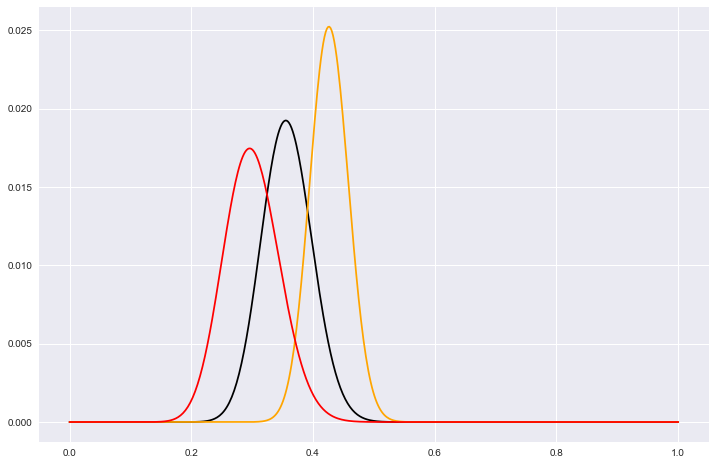

In [464]:
a,b = beta_conflation(pars=g)
y = get_beta_cdf([[a,b]]) 
plt.plot(x,y,color="black")

w3 = pars_df.theta.values*w2
w3 /= np.sum(w3)
a_w,b_w = beta_conflation(pars=g, weights=w3)
y = get_beta_cdf([[a_w,b_w]]) 
plt.plot(x,y,color="orange")

y = get_beta_cdf([[gene_a,gene_b]]) 
plt.plot(x,y,color="red")

In [465]:
beta_conflation(pars)

[17.59665747583585, 15.33775304906446]

In [478]:
prob_1_diff_2(a_w,b_w,138.43377090243672, 138.43377090243672)

0.9028482716703063

In [220]:
beta_conflation(pars=g, x_range=[0,1])

/Users/inti.pedroso/anaconda2/envs/ase_dev/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log


[29.717356076248265, 20.98257481017648]

In [345]:
gene_a/(gene_b + gene_a)

0.6837606837606838

In [475]:
pars[int(0.5*(K-1))],pro

[138.43377090243672, 138.43377090243672]

/Users/inti.pedroso/anaconda2/envs/ase_dev/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in log


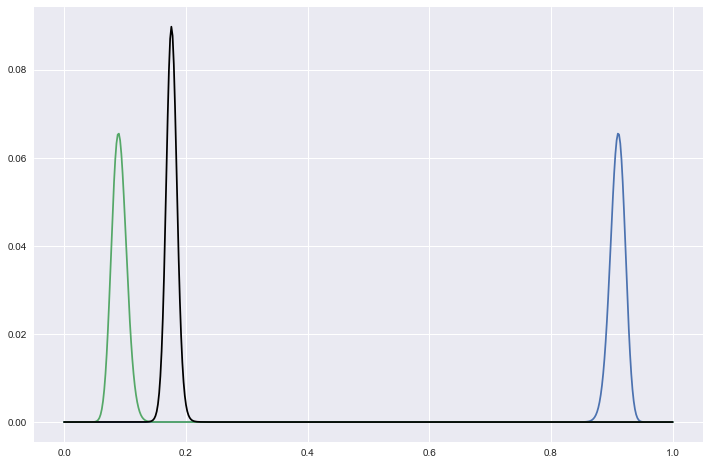

In [195]:
pars=[[500, 50],[50, 500]]
a,b = beta_conflation(pars=pars, x_range=[0,1], weights=[10,100])
x = np.linspace(0, 1, 500)
for p in pars:
    plot_beta(x,alpha=p[0],beta=p[1])

y = get_beta_cdf([[a,b]]) 
plt.plot(x,y,color="black")

In [ ]:
from scipy.special import gammaln
from scipy.misc import logsumexp

def log_dbetabinomial(x,n,a,b):
    return gammaln(n+1) + gammaln(x+a) + gammaln(n-x+b) + gammaln(a+b) - \
        (gammaln(x+1) + gammaln(n-x+1) + gammaln(a) + gammaln(b) + gammaln(n+a+b))

log_dbetabinomial(10,50,25,25)

class DirMult:
    def __init__(self,K=3,prior_counts = None):
        if prior_counts is not None:
            self.prior_counts = prior_counts
        else: 
            self.prior_counts = np.ones(K)
        
        self.alpha = self.prior_counts

    
    def update(self,counts = None):
        self.alpha += counts
            
d = dirich(prior_counts=pr_ct)
print(d.prior_counts)
d.update(pr_ct)
print(d.alpha)



In [40]:
dat2stan['x'] == dat2stan['n'] 

SyntaxError: invalid syntax (<ipython-input-40-3a0d6424997d>, line 1)

In [239]:
?expi

In [19]:
from scipy.special import expit, expi
import numpy as np

def w_average_variance(x=None,w=None):
    if w is None:
        w = np.ones_like(x)
    x = x[w>0]
    w = w[w>0]
    mean = np.ma.average(x, axis=0, weights=w)
    xm = x-mean
    sigma2 = 1./(w.sum()-1) * np.multiply(xm,w).T.dot(xm);
    return [mean, sigma2]

def beta_mom(x_hat,s2):
    one_minus_mean = 1 - x_hat
    alpha = x_hat*( x_hat*one_minus_mean/s2 - 1.0)
    beta = alpha*one_minus_mean/x_hat
    return [alpha, beta]

def get_bb_moments(x,weights):
    n = weights.shape[1]
    bb_m = np.zeros(n)
    bb_s2 = np.zeros(n)
    
    for i in xrange(weights.shape[1]):
        bb_m[i],bb_s2[i] = w_average_variance(x=x,w=weights[:,i])
    return bb_m, bb_s2

def get_combined_variance(s2,weights = None):
    if weights is None:
        weights = np.ones_like(s2)
    s2[s2<0.0] = 0.0
    s = np.power(weights, np.sum(weights)/len(weights))
    
    return np.dot(s2, weights)

def get_bb_moments_v2(k_vals,n_vals,weights=None):
    if weights is None:
        weights = np.ones_like(k_vals)
    k = k_vals[(k_vals>0) * (weights > 0)]
    n = n_vals[(k_vals>0) * (weights > 0)]
    w = weights[(k_vals>0) * (weights > 0)]
    N = len(k)
    m1,m2 = w_average_variance(x=k/n,w=w)
    print m1,m2
    mu = np.sum(k*w)/np.sum(n*w)
    
    M = (mu*(1-mu) - m2)/(m2 - (mu*(1-mu)/N)*np.sum(1/n))
    s_2 = (1.0/N)*np.sum(w * (mu*(1-mu)/k)*(1+ (n-1)/(M+1)) )
    return [mu,s_2]

In [62]:
import scipy.stats as ss
from scipy.optimize import minimize
from scipy.stats import pareto

class BetaBinomial(object):
    def __init__(self,alpha_0=None,beta_0=None,M_0=None,var_0=None,alpha=None,beta=None,p=None):
        assert p is not None
        self.name = 'BetaDistribution'
        self.p = p
        if (alpha_0 is None) and (beta_0 is None):
            if M_0:
                self.M_0 = M_0
                self.alpha_0 = self.p * self.M_0
                self.beta_0 = self.M_0 - self.alpha_0
            if var_0:
                self.alpha_0, self.beta_0 = self._beta_mom(self.p,self.var_0)
                self.M0 = self.alpha_0 + self.beta_0
        else:
            self.alpha_0 = alpha_0
            self.beta_0 = beta_0
        
        if alpha is None:
            self.alpha = self.alpha_0
            
        if beta is None:
            self.beta = self.beta_0
            
    def __str__(self):
        back = "BetaBinomial distribution: p [ %g ], alpha [ %g ], beta [ %g ]" % (self.p, self.alpha_0, self.beta_0)
        return back
    
    def _beta_mom(self,x_hat=None,s2=None):
        """Return parameters of Beta distribution taking as input the first two moments: mean and variance"""
        one_minus_mean = 1 - x_hat
        alpha = x_hat*( x_hat*one_minus_mean/s2 - 1.0)
        beta = alpha*one_minus_mean/x_hat
        return [alpha, beta]
    
    def _w_average_variance(self,x=None,w=None):
        if w is None:
            w = np.ones_like(x)
        x = x[w>0]
        w = w[w>0]
        mean = np.ma.average(x, axis=0, weights=w)
        xm = x-mean
        sigma2 = 1./(w.sum()-1) * np.multiply(xm,w).T.dot(xm);
        return [mean, sigma2]
    
    def _get_bb_moments_v2(self,k_vals=None,n_vals=None,weights=None):
        if weights is None:
            weights = np.ones_like(k_vals)
        k = k_vals[(k_vals>0) * (weights > 0)]
        n = n_vals[(k_vals>0) * (weights > 0)]
        w = weights[(k_vals>0) * (weights > 0)]
        N = len(k)
        m1,m2 = self._w_average_variance(x=k/n,w=w)
        mu = np.sum(k*w)/np.sum(n*w)

        M = (mu*(1-mu) - m2)/(m2 - (mu*(1-mu)/N)*np.sum(1/n))
        s_2 = (1.0/N)*np.sum(w * (mu*(1-mu)/k)*(1+ (n-1)/(M+1)) )
        return [mu,s_2]

    def _fit(self, data= None, weights = None):
        """Update the alpha and beta parameters on the basis of some observations and some weights (optional)"""
        assert data is not None
        
        if weights is None:
            weights = np.ones(data.shape[0], dtype=float)/data.shape[0]
        self.weights = weights
        
        m,s2 = self._get_bb_moments_v2(data[:,0],data[:,1],weights=weights )
        self.alpha, self.beta = self._beta_mom(m,s2) 
    
    def update(self, data= None, weights = None, x_n_points=100, keep_mean = False):
        """Update prior parameters alpha_0 and beta_0 by combining the data with the prior. 
        Update is done by conflation the two distribution &(Beta(self.alpha_0,self.beta_0),Beta(self.alpha,self.beta))"""
        self._fit(data= data, weights = weights)
        self.alpha_0,self.beta_0 = beta_conflation(pars=[[self.alpha_0,self.beta_0],[self.alpha,self.beta]], x_n_points=x_n_points)
        if keep_mean:
            M_0 = self.alpha_0 + self.beta_0
            self.alpha_0 = self.p * M_0
            self.beta_0 = M_0 - self.alpha_0
    
    def update_eb(self, init_M = 20, data=None, weights = None, pareto_par = 1.5 , min_val=10):
        def _fit_bb_ml_eb(pars, p, loca_data, w, pareto_par , min_val):
            M = pars[0]
            a,b = p*M, (1.0-p)*M
            fx = self._log_beta_binomial_density
            return np.dot(w, fx(loca_data[:,0], loca_data[:,1], a, b)) + pareto.logpdf(x=M, b=pareto_par, scale=min_val)

        if weights is None:
            weights = np.ones(data.shape[0])
        bnds = [(min_val, None)]
        res = minimize(_fit_bb_ml_eb, 
                       x0=[init_M], 
                       args=(self.p, data,weights, pareto_par,min_val), 
                       bounds=bnds, 
                       tol=1e-6)
        self.alpha_0 = self.p * res.x[0]
        self.beta_0 = res.x[0] - self.alpha_0
        print self.p, self.alpha_0, self.beta_0, res.success
        
    def _log_beta_binomial_density(self,k,n,alpha,beta):
        uno = gammaln(n+1) - (gammaln(k+1) + gammaln(n-k+1))
        dos = gammaln(k+alpha) + gammaln(n-k+beta) - gammaln(n+alpha+beta)
        tres = gammaln(alpha + beta) - (gammaln(alpha) + gammaln(beta))
        return uno + dos + tres
    

    def logpdf(self,data=None):
            return [ self._log_beta_binomial_density(data[i,0],data[i,1],self.alpha,self.beta)  for i in xrange(data.shape[0])] 
    

In [118]:
from tqdm import tnrange

def exp_(x):
    back = None
    try:
        back = np.exp(x)
    except OverflowError:
        back = expit(x)
    if back.any() == np.infty:
        back = expit(x)
    return back

class Mixt(object):
    """
    Define a Mixture distribution
    component_dist = list of individual distributions that form the mixture
    pi = mixture proportions 
    """
    def __init__(self, component_dist=[], pi = None, data= None, weights = None):
        self.K = len(component_dist)

        assert self.K > 1
        self.data = data
        self.weights = weights
        
        self.mixt_comp = component_dist
        if pi is None:
            pi = np.ones(self.K)/float(self.K)
        self.pi = pi
        assert self.K == self.pi.shape[0]
        
        self.log_z = None
        
        
    def __str__(self):
        back = """Mixture distribution: N Components [ %i ]""" % (len(self.mixt_comp))
        return back
    
    
    def _single_fit(self, fit_by_eb = True, null_iter=0):
        N = self.data.shape[0]
        
        if self.weights is None:
            self.weights = np.ones(self.data.shape[0])
        
        # calculate membership vectors
        self._update_mix_membership()
        
        # fit null distribution
        for i,dist in enumerate(self.mixt_comp):
            if dist.p == 0.5 and (null_iter > 0):
                for iter_ in xrange(null_iter):
                    if fit_by_eb:
                        dist.update_eb(data=self.data, weights = exp_(self.log_z[:,i])*self.weights)
                    else:
                        dist.update(data=self.data, weights = exp_(self.log_z[:,i])*self.weights,
                                    x_n_points=100,
                                    keep_mean=True)
                    self._update_mix_membership()
                    
        # update individual distributions
        for i,dist in enumerate(self.mixt_comp):
            if fit_by_eb:
                dist.update_eb(data=self.data, weights = exp_(self.log_z[:,i])*self.weights)                
            else:
                dist.update(data=self.data, weights = exp_(self.log_z[:,i])*self.weights,
                            x_n_points=100, 
                            keep_mean=True)

        self._update_mix_proportions()
       
    def _update_mix_membership(self):
        ## get the log density for each data point at each distribution
        logpdf = np.array([ dist.logpdf(data=self.data) for dist in self.mixt_comp]).T
        ## normalize the log densities to sum to 1 for each data point
        self.log_z = (logpdf.T - logaddexp.reduce(logpdf,axis=1)).T
        
    def _update_mix_proportions(self):
        # update mixture proportions
        pi = logaddexp.reduce(self.log_z,axis=0)
        self.pi = exp_(pi - logaddexp.reduce(pi))
        
    def fit(self, n_iter=1, delta = 1e-8, print_delta=False, fit_by_eb = True, null_iter=10):
        self.converged = False
        
        for i in tnrange(null_iter, desc="Fit null distribution"):
            current_params = self._extract_par_vector()
            self._single_fit(fit_by_eb=fit_by_eb, null_iter=null_iter)
            new_params = self._extract_par_vector()
            current_delta = np.sum(np.abs(current_params - new_params)/current_params)/current_params.shape[0]
            if current_delta <= delta:
                break
                
        for i in tnrange(n_iter, desc="Mixture fit"):
            current_params = self._extract_par_vector()
            self._single_fit(fit_by_eb=fit_by_eb, null_iter=0)
            new_params = self._extract_par_vector()
            current_delta = np.sum(np.abs(current_params - new_params)/current_params)/current_params.shape[0]
            if print_delta:
                print i, current_delta
            if current_delta <= delta:
                self.converged = True
                print "converged after [ %s ] iterations" % (i+1)
                break
        
        
    def _extract_par_vector(self):
        return np.hstack(
                        [self.pi, 
                         np.hstack(
                             [ [ dist.alpha_0, dist.beta_0] for dist in self.mixt_comp]) ]
                        )
    

In [122]:
means = get_mu_linear(K=7)

mixt_comp = [ BetaBinomial(p=mu,M_0=2) for mu in means]

mixt_comp[len(mixt_comp)/2].alpha_0 = 1
mixt_comp[len(mixt_comp)/2].beta_0 = 1
mixt_comp[len(mixt_comp)/2].alpha = 1
mixt_comp[len(mixt_comp)/2].beta = 1
mixt_comp[len(mixt_comp)/2].M = 2

this_data = np.vstack([dat2stan['x'],dat2stan['n']]).T.astype(float)

md = Mixt(component_dist=mixt_comp, data=this_data[:1000,:])
print(md)

for d in md.mixt_comp:
    print d

md.fit(n_iter=10, print_delta=True, fit_by_eb = True, null_iter=3)


Mixture distribution: N Components [ 7 ]
BetaBinomial distribution: p [ 0.01 ], alpha [ 0.02 ], beta [ 1.98 ]
BetaBinomial distribution: p [ 0.166667 ], alpha [ 0.333333 ], beta [ 1.66667 ]
BetaBinomial distribution: p [ 0.333333 ], alpha [ 0.666667 ], beta [ 1.33333 ]
BetaBinomial distribution: p [ 0.5 ], alpha [ 1 ], beta [ 1 ]
BetaBinomial distribution: p [ 0.666667 ], alpha [ 1.33333 ], beta [ 0.666667 ]
BetaBinomial distribution: p [ 0.833333 ], alpha [ 1.66667 ], beta [ 0.333333 ]
BetaBinomial distribution: p [ 0.99 ], alpha [ 1.98 ], beta [ 0.02 ]


0.5 5.0 5.0 True
0.5 5.0 5.0 True
0.5 5.0 5.0 True
0.01 434.5181449 43017.2963451 False
0.166666666667 33164.6398345 165823.199173 True
0.333333333333 3719.7599954 7439.5199908 False
0.5 5.0 5.0 True
0.666666666667 3624.69475462 1812.34737731 True
0.833333333333 18284.0545699 3656.81091397 True
0.99 82011.8230358 828.402252887 True
0.5 5.0 5.0 True
0.5 5.0 5.0 True
0.5 5.0 5.0 True
0.01 434.5181449 43017.2963451 False
0.166666666667 33164.6398345 165823.199173 True
0.333333333333 3719.7599954 7439.5199908 False
0.5 5.0 5.0 True
0.666666666667 3624.69475462 1812.34737731 True
0.833333333333 18284.0545699 3656.81091397 True
0.99 82011.8230358 828.402252887 True


0.01 434.5181449 43017.2963451 False
0.166666666667 33164.6398345 165823.199173 True
0.333333333333 3719.7599954 7439.5199908 False
0.5 5.0 5.0 True
0.666666666667 3624.69475462 1812.34737731 True
0.833333333333 18284.0545699 3656.81091397 True
0.99 82011.8230358 828.402252887 True
0 0.0
converged after [ 1 ] iterations


434.5181449 43017.2963451
33164.6398345 165823.199173
3719.7599954 7439.5199908
5.0 5.0
3624.69475462 1812.34737731
18284.0545699 3656.81091397
82011.8230358 828.402252887


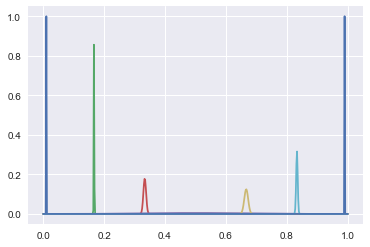

In [121]:
for d in md.mixt_comp:
    print d.alpha_0, d.beta_0
    #if d.p == 0.5:
    plot_beta(x, alpha=d.alpha_0, beta = d.beta_0, normalise=True)
    
#plt.hist(this_data[:,0]/(this_data[:,1] + 0.0), normed=True)

In [133]:
from scipy.optimize import minimize
from scipy.stats import pareto 

def _log_beta_binomial_density(k,n,alpha,beta):
    uno = gammaln(n+1) - (gammaln(k+1) + gammaln(n-k+1))
    dos = gammaln(k+alpha) + gammaln(n-k+beta) - gammaln(n+alpha+beta)
    tres = gammaln(alpha + beta) - (gammaln(alpha) + gammaln(beta))
    return uno + dos + tres

def fit_bb_ml_eb(pars, p,loca_data, w,min_val):
    M = pars[0]
    a,b = p*M, (1.0-p)*M
    #loca_data, w = args
    return np.dot(w, _log_beta_binomial_density(loca_data[:,0],loca_data[:,1],a,b)) + pareto.logpdf(x=M,b=1.5, scale=min_val)

In [132]:
def pareto_logpdf(x, par = 3, min_=1):
    back = np.log(par*(min_**par)/(x**(par+1)))
    back[ back < min_0 ] = np.log(0)
    return back
    
M = 15
min_ = 19
par = 1.5
np.log(par*(min_**par)/(M**(par+1))), pareto.logpdf(x=M,b=par, scale=min_)

(-1.9480019258977002, -inf)

In [134]:
min_val = 10
mu = 0.16666667
bnds = [(min_val, None)]
res = minimize(fit_bb_ml_eb, x0=[20], args=(mu, this_data,exp_(md.log_z[:,1]),min_val), bounds=bnds, tol=1e-6)

In [135]:
res.x, res.success

(array([ 19.96325641]), True)

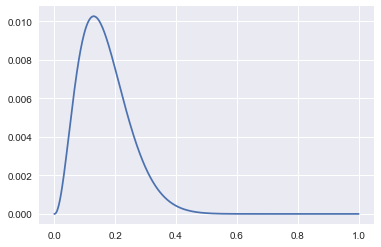

In [136]:
plot_beta(x, alpha=mu * res.x[0], beta = (1.0 - mu)*res.x[0])

In [413]:
mixt_comp = [ BetaBinomial(p=mu,M_0=50) for mu in means]

# get the log density for each data point at each distribution
logpdf = np.array([ dist.logpdf(data=this_data) for dist in mixt_comp]).T
# normalize the log densities to sum to 1 for each data point
log_z = (logpdf.T - logaddexp.reduce(logpdf,axis=1)).T
pi = logaddexp.reduce(log_z,axis=0)
pi = exp_(pi - logaddexp.reduce(pi))

0 0.5 49.5 1.39923526732e-05
0 0.314238744086 31.1096356645
1 8.33333333333 41.6666666667 0.638157291875
1 5.28105828758 26.4052914379
2 16.6666666667 33.3333333333 27.9484401919
2 12.86256996 25.7251399199
3 25.0 25.0 117.685459123
3 25.5615247969 25.5615247969
4 33.3333333333 16.6666666667 43.9015104142
4 23.6329760285 11.8164880143
5 41.6666666667 8.33333333333 9.37807639469
5 27.2804279313 5.45608558627
6 49.5 0.5 0.448342592337
6 31.2930905402 0.316091823638


In [411]:
print dist

BetaBinomial distribution: p [ 0.99 ], alpha [ 6.86417 ], beta [ 6.3542 ]
